# DatasetとDataLoaderの実装

## 学習目標
1.	物体検出で使用するDatasetクラスを作成できるようになる(分類と違ってアノテーションデータあり)
2.	SSDの学習時のデータオーギュメンテーションで、何をしているのかを理解する
3. 物体検出で使用するDataLoaderクラスを作成できるようになる

## library

In [1]:
import os.path as osp
import cv2
import random
# xmlを読み込み、加工、保存するライブラリ
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

## 学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する

In [2]:
def make_datapath_list(rootpath):
    """
    データへのパスを格納したリストを作成する
    
    Params:
    -------------
    rootpath : str
        データフォルダへのパス
    
    Returns:
    -------------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データのへのパスを格納したリスト      
    """
    
    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_tempate = osp.join(rootpath, 'Annotations', '%s.xml')
    
    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names  = osp.join(rootpath+'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath+'ImageSets/Main/val.txt')
    
    # 訓練データの画像ファイルとアノテーションファイルへのパスのリストを作成
    trian_img_list = list()
    train_anno_list = list()
    
    for line in open(train_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)      # 画像のパス  なぜタプルで囲む必要があるのか
        anno_path = (annopath_tempate % file_id)   # アノテーションのパス
        trian_img_list.append(img_path)               # リストに追加
        train_anno_list.append(anno_path)           # リストに追加
    
    # 検証データの画像ファイルとアノテーションファイルへのパスのリストを作成
    val_img_list = list()
    val_anno_list = list()
    
    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)      # 画像のパス
        anno_path = (annopath_tempate % file_id)   # アノテーションのパス
        val_img_list.append(img_path)               # リストに追加
        val_anno_list.append(anno_path)           # リストに追加
    
    return  trian_img_list, train_anno_list, val_img_list, val_anno_list

In [3]:
# template test
test_path = osp.join('JPEGImages', '%s.jpg')
file_id  = '000000'
img_path = (test_path % file_id)  
print(img_path)

JPEGImages/000000.jpg


In [4]:
# ファイルパスのリストを作成
rootpath = './data/VOCdevkit/VOC2012/'
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

# 動作確認
print(train_img_list[0])
print(train_anno_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg
./data/VOCdevkit/VOC2012/Annotations/2008_000008.xml


In [5]:
# listにlist足したらどうなるのか
ret = []
a = ['a', 'i', 'u', 'e' ,'o']
b = ['ka', 'ki', 'ku', 'ke' ,'ko']
ret += a 
print(ret)
ret += b
print(ret)

['a', 'i', 'u', 'e', 'o']
['a', 'i', 'u', 'e', 'o', 'ka', 'ki', 'ku', 'ke', 'ko']


In [6]:
# listをlistで囲ってlistに足したらどうなるのか
ret = []
a = ['a', 'i', 'u', 'e' ,'o']
b = ['ka', 'ki', 'ku', 'ke' ,'ko']
ret += [a] 
print(ret)
ret += [b]
print(ret)

# これをnumpyにしたら
import numpy as np
np.array(ret)

[['a', 'i', 'u', 'e', 'o']]
[['a', 'i', 'u', 'e', 'o'], ['ka', 'ki', 'ku', 'ke', 'ko']]


array([['a', 'i', 'u', 'e', 'o'],
       ['ka', 'ki', 'ku', 'ke', 'ko']], dtype='<U2')

## xml形式のアノテーションデータをリストに変換

In [7]:
# XML形式のアノテーションデータをpythonのリスト形式に変換するクラス

class Anno_xml2list(object):
    """
    一枚の画像に対する「ｘml形式のアノテーションデータ」を画像サイズに規格化してからリスト形式に変換する
    
    Attributeｓ
    -------------
    classes : list
        VOCのクラス名を格納したリスト
    """
    
    def __init__(self, classes):
        self.classes = classes
        
    def __call__(self, xml_path, width, hetig):
        """
        一枚の画像に対する「ｘml形式のアノテーションデータ」を画像サイズに規格化してからリスト形式に変換する
        
        Params
        -------------
        xml_path : str
            xmlファイルへのパス
        width : int
            対象画像の幅
        height : int
            対象画像の高さ
            
        Returns
        -------------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ...]
            物体のアノテーションデータを格納したリスト
            画像内に存在する物体数分の要素を持つ
            一つの画像につき５つの値が与えられている
        """
        
        # 画像内の全ての物体のアノテーションをこのリストに格納
        ret = []
        
        # xmlファイルの読み込み
        xml = ET.parse(xml_path).getroot()
        
        # 画像内にある物体(object)の数だけループする
        for obj in xml.iter('object'):
            # アノテーションで検知がdifficultに設定されているものを除外
            difficult = int(obj.find('difficult').text)   # この書きかた分かってない　find()
            if difficult == 1:
                continue
            
            # 一つの物体に対するアノテーションを格納するリスト
            bndbox = []
            name = obj.find('name').text.lower().strip()  # 物体名
            bbox = obj.find('bndbox')                                      # バウンディングボックスの情報
            
            # アノテーションの xmin, ymin, xmax, ymax, label_ind を取得し、0-1に正規化
            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            
            for pt in (pts):
                # なぜタプルで囲ったのか
                # 原点が(1,1)なので(0,0)に修正
                cur_pixel = int(bbox.find(pt).text) - 1
                
                # 幅、高さで規格化
                if pt == 'xmin' or pt == 'xmax':       # x軸の方向のときは幅で割り算
                    cur_pixel  /= width
                else:                                                    # y軸のときは高さで割り算
                    cur_pixel /= height
                
                bndbox.append(cur_pixel)
                
            # アノテーションのクラス名のindexを取得して追加
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)
            
            # res に[[xmin, ymin, xmax, ymax, label_ind]]を追加する
            ret += [bndbox]
            
        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ...]

In [8]:
# Anno_xml2listの動作確認
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 
               'diningtable', 'dog', 'horse', 'motorbike', 
               'person', 'pottedplant', 'sheep', 'sofa', 
              'train', 'tvmonitor']

# ここで__init__
transform_anno = Anno_xml2list(voc_classes)

# 画像の読み込み　OpenCVを使用
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)   # 高さ、幅、色RGB
height, width, channels = img.shape   # 画像サイズの取得

# アノテーションをリストで表示
# ここで__call__
transform_anno(val_anno_list[ind], width, height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

## 画像とアノテーションの前処理を行うクラスDataTransformを作成

In [10]:
# utils配下にあるライブラリを使う
# 入力画像の前処理クラス
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, RandomSampleCrop, Expand, RandomMirror, PhotometricDistort, Resize, ToPercentCoords, SubtractMeans

class DataTransform():
    """
    画像とアノテーションの前処理クラス
    訓練と推論で異なる動作をする
    訓練時はデータオーグメンテーション
    
    Attibutes
    -------------
    input_size : int
        リサイズ先の画像の大きさ
    color_mean : (B,G,R)
        各色チャネルの平均値
    """
    
    def __init__(self, input_size, color_mean):
#         self.input_size = input_size
#         self.color_mean = color_mean
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),          # int -> float32
                ToAbsoluteCoords(),       # アノテーションデータの規格化を戻す
                PhotometricDistort(),      # 画像の色調などをランダムに変化
                Expand(color_mean),       # 画像のキャンバスを広げる
                RandomSampleCrop(),     # 画像内の部分をランダムに抜き出す
                RandomMirror(),                # 画像反転
                ToPercentCoords(),          # アノテーションデータを0-1に規格化
                Resize(input_size),           # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)    # BGRの色の平均を引き算
            ]),
            'val': Compose([
                ConvertFromInts(),          # int -> float32
                Resize(input_size),           # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)    # BGRの色の平均を引き算
            ])
        }
    
    def __call__(self, img, phase, boxes, labels):
        """
        Params
        -------------
        phase : 'train' or 'val'
            前処理のモードを設定
        """
        return self.data_transform[phase](img, boxes, labels)
    

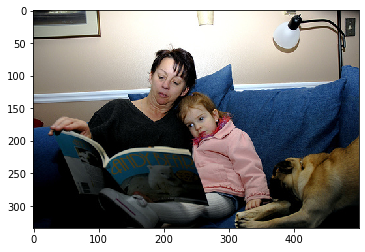

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


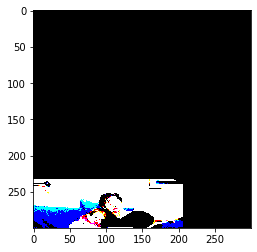

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


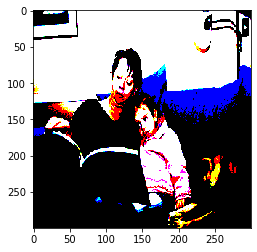

In [24]:
# DataTransformの動作確認

# 1. 画像の読み込み
ind = 
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)   # 高さ、幅、色RGB
height, width, channels = img.shape   # 画像サイズの取得

# 2. アノテーションデータをリストに
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 前処理クラスの作成
color_mean = (104, 117, 123)  # RGBの色の平均値
input_size = 300                          # ssd300では300ｘ300
transform = DataTransform(input_size, color_mean)

# 5. train画像の表示
phase = 'train'
img_transformed, boxes, labels = transform(
img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

# 6. val画像の表示
phase = 'val'
img_transformed, boxes, labels = transform(
img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

# trainデータは毎実行で変わる
# valデータは変わらない

# Datasetを作成

In [ ]:
# これまではDatasetを作るために必要なものを作っていた
# pytorchのDatasetを継承してVOCDatasetクラスを作る

class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス
    pytorchのDatasetクラスを継承
    
    Attributes
    -------------
    img_list : リスト
        画像のパスを格納したリスト
    """